In [1]:
!pip install qiskit-ibm-runtime
!pip install rustworkx
!pip install 'qiskit[visualization]'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


QiskitRuntimeService.save_account(channel="ibm_quantum", token="1806fe9c348600379dd0b79ec05bc4f90aac7498806626523e550408cd2eb096f7f53de7e8b59f066528c43bafbf3e26227a5b308af2758b96a51f7f7427d8f9", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)


<IBMBackend('ibm_sherbrooke')>


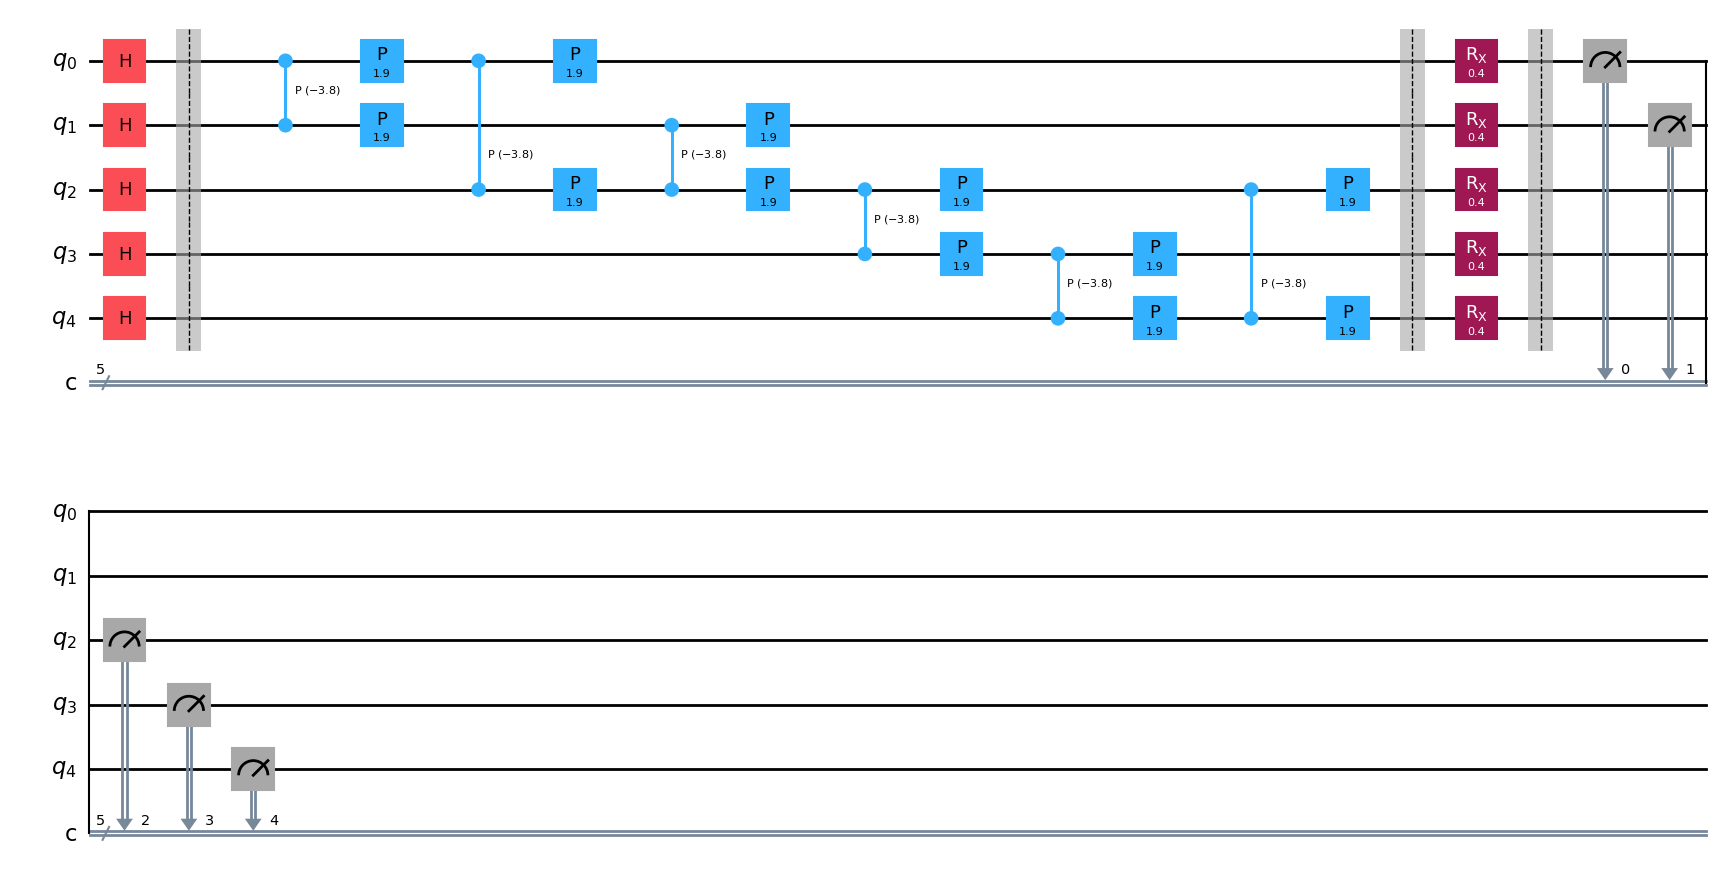


Transpilation successful!


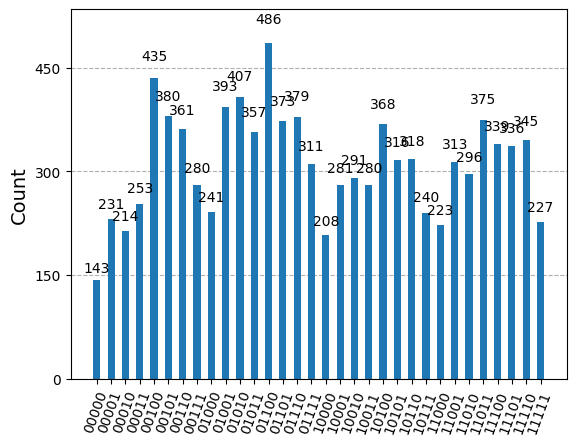

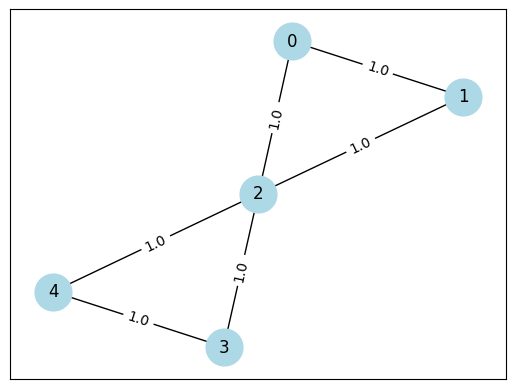

In [4]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import QuantumCircuit, transpile
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler


# useful additional packages
# import math tools
import numpy as np
# We import the tools to handle general Graphs
import networkx as nx
# import plotting tools
import matplotlib.pyplot as plt
from matplotlib import cm
from pylatexenc import *

n = 5
V = np.arange(0,n,1)
E =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)]
G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)
# Draw the network with weights
pos = nx.spring_layout(G)  # Positioning of nodes
nx.draw_networkx(G, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=12)

# Add the edge labels with weights
edge_labels = nx.get_edge_attributes(G, 'weight')  # Get the weights of the edges
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Classical Preprocessing, Determine angles
step_size = 0.1;
a_gamma = np.arange(0, np.pi, step_size)
a_beta = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)
F1 = 3-(np.sin(2*a_beta)**2*np.sin(2*a_gamma)**2-0.5*np.sin(4*a_beta)*np.sin(4*a_gamma))*(1+np.cos(4*a_gamma)**2)
result = np.where(F1 == np.amax(F1))
result[0]*0.1
result[1]*0.1
a= list(zip(result[0],result[1]))[0]
gamma = a[0]*step_size;
beta = a[1]*step_size;

# prepare the quantum and classical resisters
QAOA = QuantumCircuit(len(V), len(V))
# apply the Hadamard gates to all qubits to have uniform superposition state
QAOA.h(range(len(V)))
QAOA.barrier()
# to implement U(C, gamma), apply below equivalent circuit
# note here u1 is the phase shift gate
for edge in E:
    k = edge[0]
    l = edge[1]
    QAOA.cp(-2*gamma, k, l)
    QAOA.p(gamma, k)
    QAOA.p(gamma, l)

# to implement U(B, beta), apply R_x(2*beta) to all qubits
QAOA.barrier()
QAOA.rx(2*beta, range(len(V)))
# Measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)),range(len(V)))

display(QAOA.draw(output='mpl'))

# Transpile with explicit basis gates and coupling map
try:
    transpiled_qc = transpile(
        QAOA,
        backend=backend,
        #basis_gates=backend_config.basis_gates,  # Use backend's basis gates
        #coupling_map=backend_config.coupling_map,  # Use backend's coupling map
        optimization_level=2,  # Set optimization level (0-3)
        translation_method='synthesis' # Explicitly set the translation method to 'synthesis' or 'unroller'
    )
    print("\nTranspilation successful!")
except Exception as e:
    print(f"Error during transpilation: {e}")
    raise

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 1000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (transpiled_qc, )
job = sampler.run([pub], shots=int(1e4))
result=job.result()
bit_array = result[0].data.c

counts = result[0].data.c.get_counts()
#print(counts)
plot_histogram(counts)

